## Recommendation Model Project

#### Importing Libraries

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import SVD,accuracy
from collections import defaultdict
from surprise import Reader
from surprise import KNNWithMeans
from surprise.model_selection.split import train_test_split

#### Reading Data

In [2]:
ratings_e=pd.read_csv("ratings_Electronics.csv",names=('user_id','product_id','rating','time_stamp'))
ratings_e.head()

,user_id,product_id,rating,time_stamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Data contains user_id, product_id,ratings and timestamp colums

#### Exploratory Data Analysis

In [3]:
ratings_e.shape

(7824482, 4)

In [4]:
print("Data contains {} rows and {} columns".format(ratings_e.shape[0],ratings_e.shape[1]))
print("Number of unique product ID:",ratings_e["product_id"].nunique())
print("Number of unique user ID:",ratings_e["user_id"].nunique())

Data contains 7824482 rows and 4 columns
Number of unique product ID: 476002
Number of unique user ID: 4201696


In [5]:
ratings_e.isnull().sum()

user_id       0
product_id    0
rating        0
time_stamp    0
dtype: int64

There is no null values in the data

In [6]:
ratings_e.groupby("rating")['user_id'].count()

rating
1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347541
Name: user_id, dtype: int64

C:\Users\Asma Zain\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

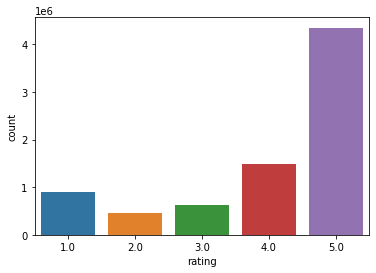

In [7]:
sns.countplot(ratings_e['rating'])

Ratings 5 have highest number of ratings than than others, then follows count of ratings 4 and 1

In [8]:
#Top 5 product_id wrt ratings 
ratings_e.groupby("product_id")['rating'].mean().sort_values(ascending=False).head()

product_id
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
Name: rating, dtype: float64

In [9]:
#Top 5 product_id wrt number of ratings given 
ratings_e.groupby("product_id")['rating'].count().sort_values(ascending=False).head()

product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: rating, dtype: int64

Product_id B0074BW614 have given highest number of rating which is 18244

In [10]:
#Top 5 user_id wrt number of ratings given 
ratings_e.groupby("user_id")['rating'].count().sort_values(ascending=False).head()

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: rating, dtype: int64

User_id 'A5JLAU2ARJ0BO' have given ratings 520 times

#### Filtering table who have rated more than 50 times

In [11]:
# consolidating table wrt count of ratings givven by a user
df=ratings_e.join(ratings_e.groupby("user_id")['rating'].count(),on='user_id',rsuffix='_user_count')

In [12]:
df.head()

,user_id,product_id,rating,time_stamp,rating_user_count
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,4
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,1
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,1
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,1


In [13]:
print("Count of users who have given ratings less than 50 times:",df[df['rating_user_count']<=50].count()[0])
print("Count of users who have given ratings more than 50 times:",df[df['rating_user_count']>50].count()[0])

Count of users who have given ratings less than 50 times: 7702311
Count of users who have given ratings more than 50 times: 122171


To make sparse data to dense we are considering the data where users have rated for more than 50 times 

In [14]:
#subset of data which contains user have rated for atleast 50 times
df_filter=df[df['rating_user_count']>50].reset_index()
df_filter.head()

,index,user_id,product_id,rating,time_stamp,rating_user_count
0,118,AT09WGFUM934H,0594481813,3.0,1377907200,110
1,177,A32HSNCNPRUMTR,0970407998,1.0,1319673600,72
2,178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000,151
3,492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200,58
4,631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000,163


In [15]:
df_filter.groupby("rating")['user_id'].count()

rating
1.0     4897
2.0     5175
3.0    11747
4.0    31480
5.0    68872
Name: user_id, dtype: int64

C:\Users\Asma Zain\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

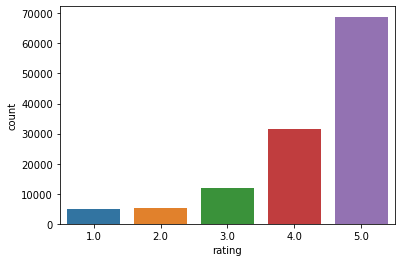

In [16]:
sns.countplot(df_filter['rating'])

After filtering data which contains user have rated for atleast 50 times we have highes number of rating in 5 

In [17]:
#Top 5 product_id wrt number of ratings given 
df_filter.groupby("product_id")['rating'].count().sort_values(ascending=False).head()

product_id
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
Name: rating, dtype: int64

Product_id 'B0088CJT4U' have given highest number of rating which is 204

In [18]:
#Top 5 user_id wrt number of ratings given 
df_filter.groupby("user_id")['rating'].count().sort_values(ascending=False).head()

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: rating, dtype: int64

User_id 'A5JLAU2ARJ0BO' have given ratings 520 times

In [19]:
df_filter=df_filter.join(df_filter.groupby("product_id")['rating'].count(),on='product_id',rsuffix="_product_count")

#### Popularty based recommender

In [20]:
# consolidating table wrt count of ratings givven by each product
df_filter.groupby("product_id")['rating',"rating_product_count"].mean().sort_values(by="rating_product_count",ascending=False).head(10)

<ipython-input-20-4b3f0e3e442b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_filter.groupby("product_id")['rating',"rating_product_count"].mean().sort_values(by="rating_product_count",ascending=False).head(10)


,rating,rating_product_count
product_id,,
B0088CJT4U,4.215686,204
B003ES5ZUU,4.858757,177
B000N99BBC,4.773006,163
B007WTAJTO,4.692308,156
B00829TIEK,4.431507,146
B008DWCRQW,4.088889,135
B00829THK0,4.409091,132
B002R5AM7C,4.118110,127
B004CLYEDC,4.666667,117


These are the top 10 product appears in Popularity based recommender model which is sorted by highest number of times user rated the product

#### Reading data in surprise format

In [21]:
reader=Reader(rating_scale=(1.0, 5.0))

In [22]:
#converting data to surprise format
data_item=Dataset.load_from_df(df_filter[['user_id', 'product_id', 'rating']],reader)

#### Splitting data

In [23]:
train_data,test_data=train_test_split(data_item,test_size=0.3)

#### Item based Recommendation using KNNWithMeans

In [33]:
KNN_cf=KNNWithMeans(k=50,sim_options={'user_based':False})
KNN_cf.fit(train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [34]:
knn_pred=KNN_cf.test(test_data)

In [35]:
knn_pred

[Prediction(uid='A1YE1IK0JYSIIE', iid='B00G96G9HW', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AWPODHOB4GFWL', iid='B00J0CVVGQ', r_ui=5.0, est=4.663349858827756, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid='AGYH5U11ZKPFB', iid='B007YWMCA8', r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1H4IVXNXWWBLV', iid='B001FA1O18', r_ui=5.0, est=4.874691974691975, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='ASCBJEPXTOU0V', iid='B00998SDM6', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2HRHF83I3NDGT', iid='B00535CMEE', r_ui=3.0, est=5.0, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A4GHPW9AAH1NY', iid='B000X2RNO6', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 

In [36]:
#function to map and convert into table format
def get_top_n(pred):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in pred:
        top_n[uid].append((iid, est, true_r))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] == user_ratings

    return top_n

In [37]:
top_n = get_top_n(knn_pred)
top_n

defaultdict(list,
            {'A1YE1IK0JYSIIE': [('B007S642BW', 5.0, 3.0),
              ('B000VX6XL6', 5.0, 5.0),
              ('B003TXRTNG', 5.0, 5.0),
              ('B004DOUOI2', 5.0, 4.0),
              ('B007FELOZO', 5.0, 3.0),
              ('B002RWKFFE', 5.0, 5.0),
              ('B00D18U63O', 5.0, 5.0),
              ('B003CVLTCW', 5.0, 4.0),
              ('B0076POAJE', 5.0, 5.0),
              ('B00DY2Y28M', 4.547505241090147, 5.0),
              ('B00GRQ8AQM', 4.35, 5.0),
              ('B00G96G9HW', 4.261579298167659, 5.0),
              ('B001W6Q654', 4.261579298167659, 3.0),
              ('B00DGIITC4', 4.261579298167659, 5.0),
              ('B008484Q6E', 4.261579298167659, 5.0),
              ('B002L3VZ3U', 4.261579298167659, 1.0),
              ('B00AKHK1BG', 4.261579298167659, 3.0),
              ('B003X4SQS8', 4.261579298167659, 4.0),
              ('B0074GWJ7A', 4.261579298167659, 5.0),
              ('B009AETXPK', 4.0, 5.0)],
             'AWPODHOB4GFWL': [('B00

In [38]:
# Top 5 recommended product for user 'A3U029B8Z5WGI2' in user based colab filtering
top5_item1=pd.DataFrame(top_n['A3U029B8Z5WGI2'],columns=['Item_id','Estimated_ratings','Actual_rating'])
top5_item[0:5]

,Item_id,Estimated_ratings,Actual_rating
0,B00JC5Y6WM,5.0,5.0
1,B0052SCU8U,5.0,5.0
2,B008MF3X9K,5.0,4.0
3,B00ENY08VU,5.0,3.0
4,B004Q3R9AQ,5.0,5.0


In [39]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse(top5_item1['Actual_rating'], top5_item1['Estimated_ratings'])

0.7328049089538432

#### User based Recommendation using KNNWithMeans

In [25]:
KNN_cf_u=KNNWithMeans(k=5,sim_options={'user_based':True})
KNN_cf_u.fit(train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
knn_pred_u=KNN_cf_u.test(test_data)

In [27]:
knn_pred_u

[Prediction(uid='A1YE1IK0JYSIIE', iid='B00G96G9HW', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AWPODHOB4GFWL', iid='B00J0CVVGQ', r_ui=5.0, est=4.777292879543359, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AGYH5U11ZKPFB', iid='B007YWMCA8', r_ui=5.0, est=4.396551724137931, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1H4IVXNXWWBLV', iid='B001FA1O18', r_ui=5.0, est=4.912985790293814, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='ASCBJEPXTOU0V', iid='B00998SDM6', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2HRHF83I3NDGT', iid='B00535CMEE', r_ui=3.0, est=5.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A4GHPW9AAH1NY', iid='B000X2RNO6', r_ui=5.0, est=4.261579298167659, details={'was_impossible': True, 'reason': 'User and/or item is u

In [29]:
top_n = get_top_n(knn_pred_u)
top_n

defaultdict(list,
            {'A1YE1IK0JYSIIE': [('B003TXRTNG', 5.0, 5.0),
              ('B00DY2Y28M', 5.0, 5.0),
              ('B004DOUOI2', 5.0, 4.0),
              ('B000VX6XL6', 4.9183076344523595, 5.0),
              ('B007S642BW', 4.549074074074074, 3.0),
              ('B009AETXPK', 4.475, 5.0),
              ('B007FELOZO', 4.475, 3.0),
              ('B002RWKFFE', 4.475, 5.0),
              ('B00D18U63O', 4.475, 5.0),
              ('B003CVLTCW', 4.475, 4.0),
              ('B0076POAJE', 4.475, 5.0),
              ('B00G96G9HW', 4.261579298167659, 5.0),
              ('B001W6Q654', 4.261579298167659, 3.0),
              ('B00DGIITC4', 4.261579298167659, 5.0),
              ('B008484Q6E', 4.261579298167659, 5.0),
              ('B002L3VZ3U', 4.261579298167659, 1.0),
              ('B00AKHK1BG', 4.261579298167659, 3.0),
              ('B003X4SQS8', 4.261579298167659, 4.0),
              ('B0074GWJ7A', 4.261579298167659, 5.0),
              ('B00GRQ8AQM', 4.255, 5.0)],
        

In [30]:
# Top 5 recommended product for user 'A3U029B8Z5WGI2' in item based colab filtering
top5_item=pd.DataFrame(top_n['A3U029B8Z5WGI2'],columns=['Item_id','Estimated_ratings','Actual_rating'])
top5_item[0:5]

,Item_id,Estimated_ratings,Actual_rating
0,B00JC5Y6WM,5.0,5.0
1,B0052SCU8U,5.0,5.0
2,B008MF3X9K,5.0,4.0
3,B00ENY08VU,5.0,3.0
4,B004Q3R9AQ,5.0,5.0


In [31]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse(top5_item['Actual_rating'], top5_item['Estimated_ratings'])

0.9593562697034262

In [40]:
#Tabulating 3 models RMSE
rmse_data={'Item based Collaborative Filtering':rmse(top5_item1['Actual_rating'], top5_item1['Estimated_ratings']),
            'User based Collaborative Filtering':rmse(top5_item['Actual_rating'], top5_item['Estimated_ratings'])}
rmse_df=pd.DataFrame(list(rmse_data.items()),columns=['Model','RMSE'])
rmse_df

,Model,RMSE
0,Item based Collaborative Filtering,0.732805
1,User based Collaborative Filtering,0.959356


From the above three model, we can go for Item based Collaborative Filtering which have low RMSE when compared to User based Collaborative Filtering

#### Conclusion

From the above analysis, we have got following insights from the data

* Data contains 7824482 rows and 4 columns
* Number of unique product ID: 476002
* Number of unique user ID: 4201696
* There is no null values in the data
* Filtering data who have rated more than 50 times to make sparse matrix and dense matrix
* After filter, we have Product_id 'B0088CJT4U' have rated 18244 times and User_id 'A5JLAU2ARJ0BO' have rated 520 times
* Built popularity based recommender model and obtained top 10 products
* We have tried Item based Collaborative Filtering and User based Collaborative Filtering and we achieved Item based Collaborative Filtering with least RMSE 0.73
